In [ ]:
!pip install pulp
import pulp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#**Зачетная работа по курсу "Системы компьютерной математики"**
##Вариант 49. "Задача коммивояжера"
##Выполнила: Шведова Виталина (3822Б1ПР1)


### Формулировка задачи

Реализовать новую версию кода для решения задачи коммивояжера. В отличие от способа, разобранного на лекциях, для обозначения дороги из города $i$ в город $j$ необходимо использовать только одну переменную.

### Общие сведения
*Задача коммивояжёра* (или TSP от англ. travelling salesman problem) — одна из задач комбинаторной оптимизации, заключающаяся в поиске самого выгодного маршрута, проходящего через указанные города хотя бы по одному разу с последующим возвратом в исходный город.

Рассмотрим решение задачи для постоения пути через 50 городов (n = 50), что уже позволит увидеть различия в двух реализованных методах.

### **Исходный вариант решения задачи**


In [ ]:
n = 50
np.random.seed(42)
x = 1.5*np.random.rand(n)
y = np.random.rand(n)

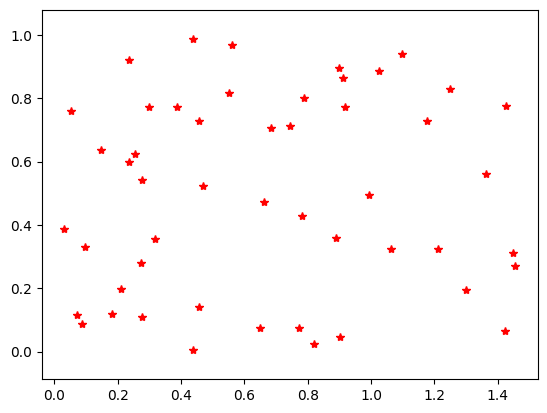

In [ ]:
plt.plot(x, y, '*', markerfacecolor = 'red', markeredgecolor = 'red')
plt.axis('equal')
pass

In [ ]:
xi, xj = np.meshgrid(x, x)
yi, yj = np.meshgrid(y, y)
dist = np.hypot(xi - xj, yi - yj)

###Формулируем ЗЦЛП

In [ ]:
prob = pulp.LpProblem("Traveling Salesman Problem", pulp.LpMinimize)
roads = pulp.LpVariable.dicts("Road", (range(n), range(n)), 0, 1, pulp.LpInteger)
for i in range(n):
    prob += pulp.lpSum([roads[i][j] for j in range(n)]) == 1
for j in range(n):
    prob += pulp.lpSum([roads[i][j] for i in range(n)]) == 1
for i in range(n):
    prob += roads[i][i] == 0
prob += pulp.lpSum([dist[i][j]*roads[i][j] for i in range(n) for j in range(n)]), "Objective Function" 

###Решаем задачу

In [ ]:
prob.solve()
print("Status:", pulp.LpStatus[prob.status])

Status: Optimal


In [ ]:
def findPath(roads):
    path = [0]*n
    for i in range(n):
        for j in range(n):
            if pulp.value(roads[i][j]) == 1:
                path[i] = j
    return path            

In [ ]:
path = findPath(roads)
print(path)

[19, 43, 38, 30, 31, 26, 29, 33, 48, 35, 32, 34, 25, 14, 13, 46, 22, 20, 27, 5, 17, 49, 16, 0, 41, 12, 44, 18, 45, 6, 3, 4, 10, 7, 11, 9, 23, 42, 2, 47, 21, 24, 37, 1, 36, 28, 15, 39, 8, 40]


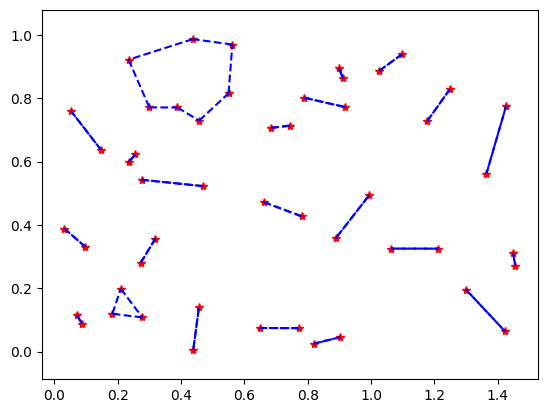

In [ ]:
plt.plot(x, y, '*', markerfacecolor = 'red', markeredgecolor = 'red')
plt.axis('equal')
for i in range(n):
    plt.plot((x[i], x[path[i]]), (y[i], y[path[i]]), '--b')

###Динамическое исключение контуров

In [ ]:
def findTours(path):
    ipath = [True]*len(path)
    tours = []
    while True in ipath:
        i0 = ipath.index(True)
        ipath[i0] = False
        tour = [i0]
        i = path[i0]
        while i != i0:
            tour.append(i)
            ipath[i] = False
            i = path[i]
        tours.append(tour)
    return tours 

In [ ]:
findTours(path)

[[0, 19, 5, 26, 44, 36, 23],
 [1, 43],
 [2, 38],
 [3, 30],
 [4, 31],
 [6, 29],
 [7, 33],
 [8, 48],
 [9, 35],
 [10, 32],
 [11, 34],
 [12, 25],
 [13, 14],
 [15, 46],
 [16, 22],
 [17, 20],
 [18, 27],
 [21, 49, 40],
 [24, 41],
 [28, 45],
 [37, 42],
 [39, 47]]

In [ ]:
itCount = 0
while True:
    itCount += 1
    print('Iteration No', itCount, end = '')
    result = prob.solve()
    if result != 1:
        print('\nSomething Wrong!')
        break
    path = findPath(roads) 
    tours = findTours(path)
    print('  Number of tours = ', len(tours))
    if len(tours) == 1:
        break
    for tour in tours:
        prob += pulp.lpSum([roads[i][j] for i in tour for j in tour]) <= len(tour) - 1    

Iteration No 1  Number of tours =  22
Iteration No 2  Number of tours =  7
Iteration No 3  Number of tours =  5
Iteration No 4  Number of tours =  7
Iteration No 5  Number of tours =  4
Iteration No 6  Number of tours =  3
Iteration No 7  Number of tours =  2
Iteration No 8  Number of tours =  2
Iteration No 9  Number of tours =  1


Total Distanse =  7.287766432262201


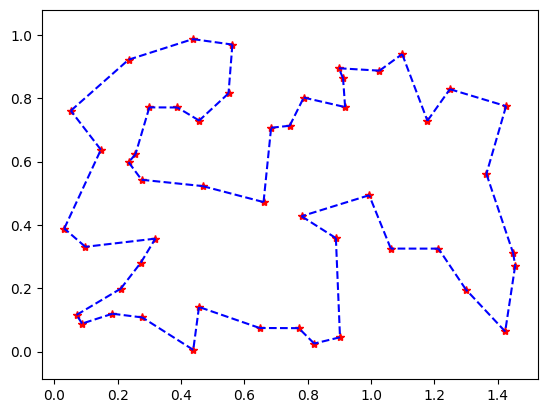

In [ ]:
plt.plot(x, y, '*', markerfacecolor = 'red', markeredgecolor = 'red')
plt.axis('equal')
for i in range(n):
    plt.plot((x[i], x[path[i]]), (y[i], y[path[i]]), '--b')
print("Total Distanse = ", pulp.value(prob.objective))

Итоговое количество итераций = 9

Среднее время выполнения = 11.814617

### **Теперь рассмотрим оптимизированный способ решения**

In [ ]:
n = 50
np.random.seed(42)
x = 1.5*np.random.rand(n)
y = np.random.rand(n)

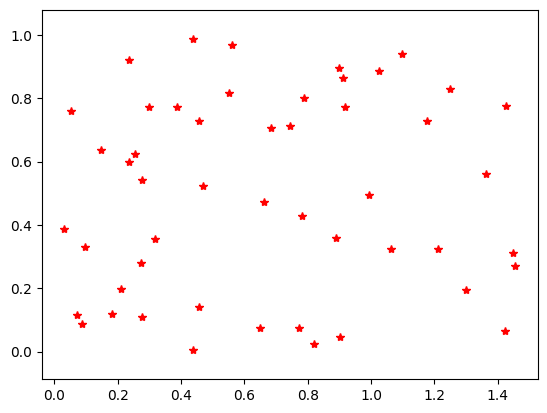

In [ ]:
plt.plot(x, y, '*', markerfacecolor = 'red', markeredgecolor = 'red')
plt.axis('equal')
pass

###Формулируем задачу и устанавливаем начальные ограничения:


*   в каждый город въезжаем ровно один раз;
*   из каждого города выезжаем ровно один раз;

В данной реализации решения не нужно проверять условие "из города в тот же город ехать нельзя", потому что это учитывается при создании переменных.


In [ ]:
prob = pulp.LpProblem("Traveling Salesman Problem", pulp.LpMinimize)
roads = pulp.LpVariable.dicts("Road", ((i, j) for i in range(n) for j in range(i + 1, n)), 0, 1, pulp.LpInteger)
for i in range(n):
    prob += pulp.lpSum([roads[(i,j)] for j in range(i + 1, n)]) + pulp.lpSum([roads[(j,i)] for j in range(0, i)]) == 2
prob += pulp.lpSum([dist[i][j] * roads[i,j] for i in range(n) for j in range(i + 1, n)]), "Objective Function" 

### Решаем задачу

In [ ]:
prob.solve()
print("Status:", pulp.LpStatus[prob.status])
print("Total: ", pulp.value(prob.objective))

Status: Optimal
Total:  6.967282225225249


In [ ]:
def findPath(roads):
    path = [[] for _ in range(n)]
    for i in range(n):
        for j in range(i + 1, n):
            if pulp.value(roads[i, j]) == 1:
                path[i].append(j)
                path[j].append(i)
    return path     

In [ ]:
path = findPath(roads)
for i in range(n):
    print(f'{i}: {path[i]}')

0: [19, 23]
1: [12, 43]
2: [25, 38]
3: [30, 38]
4: [15, 31]
5: [19, 42]
6: [29, 40]
7: [33, 35]
8: [27, 48]
9: [35, 45]
10: [32, 37]
11: [33, 34]
12: [1, 25]
13: [14, 46]
14: [13, 21]
15: [4, 31]
16: [18, 22]
17: [20, 41]
18: [16, 22]
19: [0, 5]
20: [17, 30]
21: [14, 49]
22: [16, 18]
23: [0, 24]
24: [23, 41]
25: [2, 12]
26: [36, 44]
27: [8, 48]
28: [45, 47]
29: [6, 32]
30: [3, 20]
31: [4, 15]
32: [10, 29]
33: [7, 11]
34: [11, 43]
35: [7, 9]
36: [26, 44]
37: [10, 42]
38: [2, 3]
39: [46, 47]
40: [6, 49]
41: [17, 24]
42: [5, 37]
43: [1, 34]
44: [26, 36]
45: [9, 28]
46: [13, 39]
47: [28, 39]
48: [8, 27]
49: [21, 40]


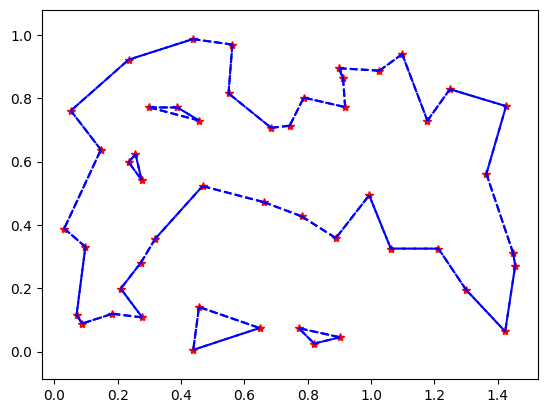

In [ ]:
plt.plot(x, y, '*', markerfacecolor = 'red', markeredgecolor = 'red')
plt.axis('equal')
for i in range(n):
    for j in path[i]:
        plt.plot((x[i], x[j]), (y[i], y[j]), '--b')       

### Динамическое исключение контуров

В силу задаваемых условий даже при первом findPath будут циклические графы как минимум с тремя вершинами

In [ ]:
def findTours(path):
    ipath = [True]*len(path)
    tours = []
    while True in ipath:
        i0 = ipath.index(True)
        ipath[i0] = False
        tour = [i0]
        cur = i0
        while True:
            i1, i2 = path[cur]
            if not ipath[i1] and not ipath[i2]:
                break
            cur = i1 if ipath[i1] else i2
            ipath[cur] = False
            tour.append(cur)
        tours.append(tour)
    return tours    

In [ ]:
findTours(path)

[[0,
  19,
  5,
  42,
  37,
  10,
  32,
  29,
  6,
  40,
  49,
  21,
  14,
  13,
  46,
  39,
  47,
  28,
  45,
  9,
  35,
  7,
  33,
  11,
  34,
  43,
  1,
  12,
  25,
  2,
  38,
  3,
  30,
  20,
  17,
  41,
  24,
  23],
 [4, 15, 31],
 [8, 27, 48],
 [16, 18, 22],
 [26, 36, 44]]

In [ ]:
itCount = 0
while True:
    itCount += 1
    print('Iteration No', itCount, end = '')
    result = prob.solve()
    if result != 1:
        print('\nSomething Wrong!')
        break
    path = findPath(roads) 
    tours = findTours(path)
    print('  Number of tours = ', len(tours))
    if len(tours) == 1:
        break
    for tour in tours:
        tour = sorted(tour)
        prob += pulp.lpSum([roads[tour[i],tour[j]] for i in range(len(tour)) for j in range(i + 1, len(tour))]) <= len(tour) - 1    

Iteration No 1  Number of tours =  5
Iteration No 2  Number of tours =  5
Iteration No 3  Number of tours =  6
Iteration No 4  Number of tours =  3
Iteration No 5  Number of tours =  3
Iteration No 6  Number of tours =  2
Iteration No 7  Number of tours =  1


Total Distanse =  7.287766432262201


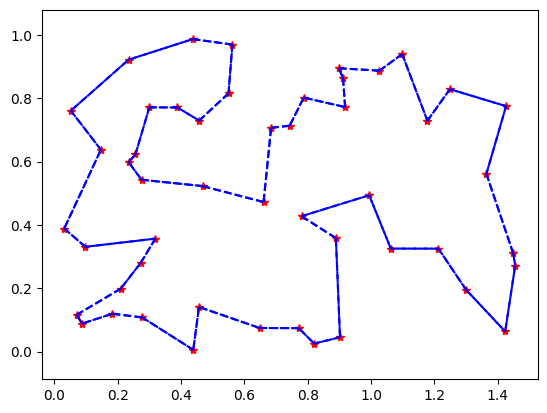

In [ ]:
plt.plot(x, y, '*', markerfacecolor = 'red', markeredgecolor = 'red')
plt.axis('equal')
for i in range(n):
    for j in path[i]:
        plt.plot((x[i], x[j]), (y[i], y[j]), '--b')
print("Total Distanse = ", pulp.value(prob.objective))

Итоговое количество итераций = 7

Среднее время выполнения = 2.496127

###**Выводы**

* новая версия кода для решения задачи коммивояжера действительно является более оптимизированной и позволяет получить ответ быстрее исходного способа - затрачивается меньшее количество итераций;

*   также удалось в несколько раз сократить время поиска решения;

* с математической точки зрения, в исходной реализации решения использовалась прямоугольная матрица, а в оптимизированной версии, фактически, только ее половина, т.е. используется меньшее количество значений.


